cg_coef, cg_table, complex_multiplication, tensor_coupling, WignerDなどのtest. イケてる.

In [257]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
plt.set_cmap('viridis')
%matplotlib inline
import theano
import theano.tensor as T 

import TN_utils
reload(TN_utils)

import blocks

In [157]:
TN_utils.clebsch_Gordan_coef(j=0, m=0, j1=0, m1=0, j2=0, m2=0)

1.0

In [158]:
# invalidな値はを弾けてる
TN_utils.clebsch_Gordan_coef(j=4, m=0, j1=0, m1=0, j2=0, m2=0)

AssertionError: 

In [185]:
TN_utils.clebsch_Gordan_coef(j=3, m=2, j1=2, m1=2, j2=2, m2=0)

0.7071067811865476

In [200]:
TN_utils.cg_table(2, 2, 0)

array([[[ 1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 0.]],

       [[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 1.]]])

In [105]:
# あってる
def c_mul(y1, y2):
        """x: (N, 2, n_tensors)"""
        return T.stacklists([y1[:, 0]*y2[:, 0] - y1[:, 1]*y2[:, 1], y1[:, 0]*y2[:, 1] + y1[:, 1]*y2[:, 0]]).transpose(1, 0, 2)
x1 = T.tensor3()
x2 = T.tensor3()
out = c_mul(x1, x2)
f = theano.function(inputs=[x1, x2],
                    outputs=[out])
a = np.zeros((2, 2, 3))
b = np.zeros((2, 2, 3))
a[:, :] = np.array((1, 2))[:, np.newaxis]
b[:, :] = np.array((3, 4))[:, np.newaxis]
print a
print b
c = f(TN_utils.floatX(a), TN_utils.floatX(b))[0]
print c, c.shape

[[[ 1.  1.  1.]
  [ 2.  2.  2.]]

 [[ 1.  1.  1.]
  [ 2.  2.  2.]]]
[[[ 3.  3.  3.]
  [ 4.  4.  4.]]

 [[ 3.  3.  3.]
  [ 4.  4.  4.]]]
[[[ -5.  -5.  -5.]
  [ 10.  10.  10.]]

 [[ -5.  -5.  -5.]
  [ 10.  10.  10.]]] (2, 2, 3)


In [239]:
def tensor_coupling(x1, x2, j, j1, j2):
    """
        x: (N, dim, n_tensors)
    """    
    def c_mul(y1, y2):
        """x: (N, 2, n_tensors)"""
        return T.stacklists([y1[:, 0]*y2[:, 0] - y1[:, 1]*y2[:, 1], y1[:, 0]*y2[:, 1] + y1[:, 1]*y2[:, 0]]).transpose(1, 0, 2)
    cg_table = TN_utils.cg_table(j, j1, j2)
    tensor = []
    for m in range(-j, j+1):
        tmp = 0
        for m1, m2 in [(m1, m2) for m1 in range(-j1, j1+1) for m2 in range(-j2, j2+1) if m == m1+m2]:
            tmp += cg_table[m, m1, m2]*c_mul(x1[:, 2*(m1+j1) : 2*(m1+j1)+2], x2[:, 2*(m2+j2) : 2*(m2+j2)+2])
        tensor.append(tmp)
    out = T.concatenate(tensor, axis=1)
    return out

In [258]:
tensor_coupling = blocks.tensor_coupling

In [259]:
# (0, 0) to 0 のときは、ただのelementwiseな掛け算
# あってる!
x1 = T.tensor3()
x2 = T.tensor3()
out = tensor_coupling(x1, x2, j=0, j1=0, j2=0)
f = theano.function(inputs=[x1, x2],
                    outputs=[out])
shape1 = (2, 1, 3)
shape2 = (2, 1, 3)
tens1 = TN_utils.floatX(np.arange(np.prod(shape1)).reshape(shape1))
tens1 = TN_utils.floatX(np.concatenate((tens1, np.zeros(shape1)), axis=1))
print 'tens1'
print tens1, tens1.shape
tens2 = TN_utils.floatX(2*np.arange(np.prod(shape2)).reshape(shape2))
tens2 = TN_utils.floatX(np.concatenate((tens2, np.zeros(shape2)), axis=1))
print 'tens2'
print tens2, tens2.shape
tens3 = f(tens1, tens2)[0]
print 'tens3'
print tens3, tens3.shape

tens1
[[[ 0.  1.  2.]
  [ 0.  0.  0.]]

 [[ 3.  4.  5.]
  [ 0.  0.  0.]]] (2, 2, 3)
tens2
[[[  0.   2.   4.]
  [  0.   0.   0.]]

 [[  6.   8.  10.]
  [  0.   0.   0.]]] (2, 2, 3)
tens3
[[[  0.   2.   8.]
  [  0.   0.   0.]]

 [[ 18.  32.  50.]
  [  0.   0.   0.]]] (2, 2, 3)


In [40]:
hardi2 = TN_utils.load_hardi(i_order=1)
# 6番目の要素はほぼ０
plt.hist(hardi2[0][:, :, 5].flatten(), bins=100)
plt.ylim(0, 10)
data_set, norm_coef, gt_norm_coef = TN_utils.preprocess(hardi2[0], hardi2[1], hardi2[2])
plt.hist(data_set[0][:, 5].flatten(), bins=100)
plt.ylim(0, 10)

(430080, 43, 10) (430080, 10) (430080,)


In [260]:
# (2, 2) to 0で回転させてもinvariantか見よう
# とりあえずそれっぽいa0の値はでた まだ回転はさせてない
x1 = T.tensor3()
x2 = T.tensor3()
out = tensor_coupling(x1, x2, j=0, j1=2, j2=2)
f_0_22 = theano.function(inputs=[x1, x2],
                    outputs=[out])

In [261]:
a2 = data_set[0][:2, :, :3]
print a2
print a2.shape

b2 = data_set[0][2:4, :, :3]
print b2
print b2.shape
c0 = f_0_22(a2, b2)[0]
print c0
print c0.shape

[[[  8.56593922e-02  -1.49386920e-04  -3.28824460e-03]
  [  6.16603680e-02   2.40671900e-04  -2.03959923e-02]
  [ -1.89289138e-01   2.79454794e-03  -1.27256662e-02]
  [ -7.31389374e-02   5.02372440e-03  -1.19942417e-02]
  [ -1.04597576e-01   4.73971963e-02   4.80040610e-02]
  [ -1.66741046e-07   3.94356725e-08  -1.42993430e-08]
  [  1.89289019e-01  -2.79444316e-03   1.27256392e-02]
  [ -7.31391087e-02   5.02354652e-03  -1.19943004e-02]
  [  8.56597051e-02  -1.49376967e-04  -3.28833167e-03]
  [ -6.16600253e-02  -2.40654103e-04   2.03958862e-02]]

 [[ -4.38101180e-02   1.30733021e-03  -4.59400862e-02]
  [ -5.00477888e-02   2.82440335e-04   5.97897060e-02]
  [  2.11181298e-01   1.60171948e-02   1.49952054e-01]
  [  2.52319366e-01   1.71046180e-03   9.70959067e-02]
  [ -6.19091809e-01   7.81089664e-02  -1.53909266e-01]
  [  3.34826609e-07  -1.26961353e-07   1.77356199e-07]
  [ -2.11181074e-01  -1.60172246e-02  -1.49951905e-01]
  [  2.52319783e-01   1.71052653e-03   9.70961079e-02]
  [ -4.3

(5, 5) (9, 9)


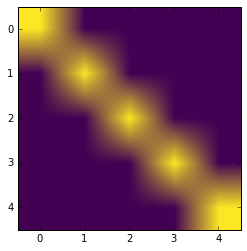

In [242]:
from sympy.physics.quantum.spin import Rotation
from sympy import pi, symbols
def wignerD(j, alpha=pi/2., beta=pi/2., gamma=pi/2.):
    A = np.zeros((2*j+1, 2*j+1), dtype=complex)
    for m in range(-j, j+1): 
        for mp in range(-j, j+1):
            A[m+j, mp+j] = Rotation.D(j, m, mp, alpha, beta, gamma).doit()  
    return A

print wignerD(2).shape, wignerD(4).shape

def rotate_tensor(x_float, D):
    x_comp = TN_utils.vec2comp(x_float)
    return TN_utils.floatX(TN_utils.comp2vec(np.tensordot(np.conj(D), x_comp, axes=(1, 1)).transpose(1, 0, 2)))

D2 = wignerD(2)
# unitaryになってる
plt.imshow(abs(np.dot(np.conjugate(D2).T, D2)))

In [262]:
# c0は回転してない!すばら!
a2_r = rotate_tensor(a2, D2)
print a2_r, a2_r.shape
b2_r = rotate_tensor(b2, D2)
print b2_r, b2_r.shape

c0_r = f_0_22(a2_r, b2_r)[0]
print c0_r - c0

[[[  1.06882364e-01  -2.90995166e-02  -3.10405362e-02]
  [ -1.89288884e-01   2.79447576e-03  -1.27256708e-02]
  [  6.16601370e-02   2.40715395e-04  -2.03959532e-02]
  [ -7.31388628e-02   5.02364058e-03  -1.19943144e-02]
  [ -5.26123047e-02  -2.35156436e-02  -1.99747160e-02]
  [ -1.26505867e-07  -3.06162242e-08   7.21657258e-08]
  [ -6.16602562e-02  -2.40610621e-04   2.03959253e-02]
  [ -7.31391758e-02   5.02363034e-03  -1.19942278e-02]
  [  1.06882535e-01  -2.90993378e-02  -3.10404785e-02]
  [  1.89289272e-01  -2.79451534e-03   1.27256345e-02]]

 [[  3.57209712e-01  -4.71780784e-02   7.12798461e-02]
  [  2.11180925e-01   1.60172861e-02   1.49951890e-01]
  [ -5.00475541e-02   2.82428926e-04   5.97897321e-02]
  [  2.52319157e-01   1.71049649e-03   9.70959961e-02]
  [  3.63202602e-01  -4.06556316e-02   1.33219525e-01]
  [ -1.91310736e-08   6.77580516e-08  -1.50272257e-07]
  [  5.00477776e-02  -2.82458728e-04  -5.97895831e-02]
  [  2.52319992e-01   1.71049184e-03   9.70960185e-02]
  [  3.5

In [248]:
hardi4 = TN_utils.load_hardi(i_order=2)
data_set4, norm_coef, gt_norm_coef = TN_utils.preprocess(hardi4[0], hardi4[1], hardi4[2])

(430080, 37, 18) (430080, 18) (430080,)
(21485, 18, 37)
(21485, 18)
(5372, 18, 37)
(5372, 18)


In [263]:
x1 = T.tensor3()
x2 = T.tensor3()
out = tensor_coupling(x1, x2, j=4, j1=2, j2=4)
f_4_24 = theano.function(inputs=[x1, x2],
                    outputs=[out])

In [264]:
d2 = data_set[0][:2, :, :3]
print d2
print d2.shape

e4 = data_set4[0][2:4, :, :3]
print e4
print e4.shape
f4 = f_4_24(d2, e4)[0]
print f4
print f4.shape

[[[  8.56593922e-02  -1.49386920e-04  -3.28824460e-03]
  [  6.16603680e-02   2.40671900e-04  -2.03959923e-02]
  [ -1.89289138e-01   2.79454794e-03  -1.27256662e-02]
  [ -7.31389374e-02   5.02372440e-03  -1.19942417e-02]
  [ -1.04597576e-01   4.73971963e-02   4.80040610e-02]
  [ -1.66741046e-07   3.94356725e-08  -1.42993430e-08]
  [  1.89289019e-01  -2.79444316e-03   1.27256392e-02]
  [ -7.31391087e-02   5.02354652e-03  -1.19943004e-02]
  [  8.56597051e-02  -1.49376967e-04  -3.28833167e-03]
  [ -6.16600253e-02  -2.40654103e-04   2.03958862e-02]]

 [[ -4.38101180e-02   1.30733021e-03  -4.59400862e-02]
  [ -5.00477888e-02   2.82440335e-04   5.97897060e-02]
  [  2.11181298e-01   1.60171948e-02   1.49952054e-01]
  [  2.52319366e-01   1.71046180e-03   9.70959067e-02]
  [ -6.19091809e-01   7.81089664e-02  -1.53909266e-01]
  [  3.34826609e-07  -1.26961353e-07   1.77356199e-07]
  [ -2.11181074e-01  -1.60172246e-02  -1.49951905e-01]
  [  2.52319783e-01   1.71052653e-03   9.70961079e-02]
  [ -4.3

(array([  3.,   4.,  14.,  76.,   5.,   1.,   2.,   1.,   1.,   1.]), array([ -8.16918316e-09,  -5.56840868e-09,  -2.96763419e-09,
        -3.66859701e-10,   2.23391479e-09,   4.83468927e-09,
         7.43546376e-09,   1.00362382e-08,   1.26370127e-08,
         1.52377872e-08,   1.78385617e-08]), <a list of 10 Patch objects>)


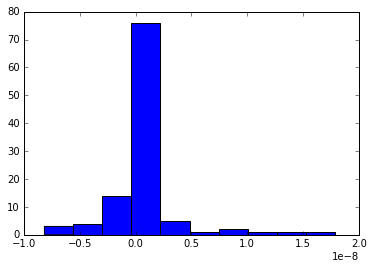

In [265]:
D4 = wignerD(4)
# f4も一緒にD4で回転してる。OK!
d2_r = rotate_tensor(d2, D2)
e4_r = rotate_tensor(e4, D4)

f4_r = f_4_24(d2_r, e4_r)[0]

# 誤差ほとんど0
print plt.hist((f4 - rotate_tensor(f4_r, D4)).flatten())

In [266]:
tensor_coupling

<function blocks.tensor_coupling>